In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
import zipfile
import cv2
from keras import layers
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import *
from keras import regularizers
from keras.layers import InputLayer
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
import sklearn
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from shutil import copyfile , move
from tqdm import tqdm
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aysendegerli/qatacov19-dataset

100% 4.79G/4.79G [01:37<00:00, 42.7MB/s]
100% 4.79G/4.79G [01:38<00:00, 52.5MB/s]


In [4]:
import zipfile
filename = "qatacov19-dataset.zip"
with zipfile.ZipFile(filename, 'r') as zipf:
  zipf.extractall()
  print("Done")

Done


In [5]:
!rm qatacov19-dataset.zip

In [6]:
image_files = sorted(os.listdir("/content/drive/MyDrive/Data Sets/Four Classes/covid_segmentation"))
mask_files = sorted(os.listdir("/content/drive/MyDrive/Data Sets/Four Classes/masks"))
image_files_train = image_files[:2000]
mask_files_train = mask_files[:2000]
image_files_validation = image_files[2000:2452]
mask_files_validation = mask_files[2000:2452]
image_files_test = image_files[2452:2904]
mask_files_test = mask_files[2452:2904]

In [ ]:
X_train = np.zeros(shape=(2000,224,224,1))
Y_train = np.zeros(shape=(2000,224,224,1))
X_valid = np.zeros(shape=(452,224,224,1))
Y_valid = np.zeros(shape=(452,224,224,1))
X_test = np.zeros(shape=(452,224,224,1))
Y_test = np.zeros(shape=(452,224,224,1))

In [7]:
X_test = np.zeros(shape=(452,224,224,1))
Y_test = np.zeros(shape=(452,224,224,1))

In [ ]:
image_path = "/content/QaTa-COV19/QaTa-COV19/Images"
mask_path = "/content/QaTa-COV19/QaTa-COV19/Ground-truths"
for i in tqdm(range(len(image_files_train))): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,image_files_train[i]),0),(224, 224))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,mask_files_train[i]),0),(224, 224))

            X_train[i,:,:,0] = im
            Y_train[i,:,:,0] = mask
for i in tqdm(range(len(image_files_validation))): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,image_files_validation[i]),0),(224, 224))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,mask_files_validation[i]),0),(224, 224))

            X_valid[i,:,:,0] = im
            Y_valid[i,:,:,0] = mask
for i in tqdm(range(len(image_files_test))): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,image_files_test[i]),0),(224, 224))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,mask_files_test[i]),0),(224, 224))

            X_test[i,:,:,0] = im
            Y_test[i,:,:,0] = mask

100%|██████████| 452/452 [00:00<00:00, 684.66it/s]


In [8]:
image_path = "/content/QaTa-COV19/QaTa-COV19/Images"
mask_path = "/content/QaTa-COV19/QaTa-COV19/Ground-truths"

for i in tqdm(range(len(image_files_test))): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,image_files_test[i]),0),(224, 224))
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,mask_files_test[i]),0),(224, 224))

            X_test[i,:,:,0] = im
            Y_test[i,:,:,0] = mask

100%|██████████| 452/452 [00:00<00:00, 968.09it/s]


In [9]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(224,224,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

model = unet(input_size=(224,224,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
model.load_weights(filepath = '/content/drive/MyDrive/Colab Notebooks/Segmentation/Lung Segmentation/Lung Segmentation Without Generator/For Densenet Segmentation/model_checkpoint_loss.h5')
train_Lungs_masks = model.predict(X_train,verbose=1)
valid_Lungs_masks = model.predict(X_valid,verbose=1)
test_Lungs_masks = model.predict(X_test,verbose=1)

15/15 [==============================] - 47s 181ms/step


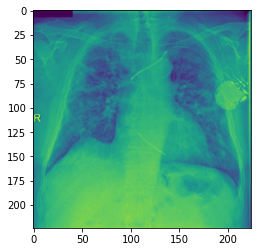

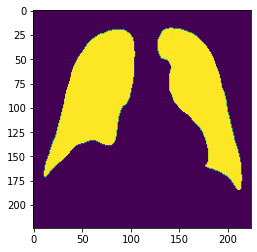

In [ ]:
j=np.random.randint(0,2000)
plt.imshow(X_train[j,:,:,0])
plt.show()
plt.imshow(train_Lungs_masks[j,:,:,0])
plt.show()

In [ ]:
train_Lungs_only = np.zeros(shape=(2000,224,224,3))
valid_Lungs_only = np.zeros(shape=(452,224,224,3))
test_Lungs_only = np.zeros(shape=(452,224,224,3))

In [ ]:
for image in tqdm(range(len(image_files_train))):
  train_Lungs_only[image,:,:,0] = cv2.resize(cv2.bitwise_and(X_train[image], X_train[image], mask = train_Lungs_masks[image].astype(np.uint8)),(224, 224))
  train_Lungs_only[image,:,:,1] = cv2.resize(cv2.bitwise_and(X_train[image], X_train[image], mask = train_Lungs_masks[image].astype(np.uint8)),(224, 224))
  train_Lungs_only[image,:,:,2] = cv2.resize(cv2.bitwise_and(X_train[image], X_train[image], mask = train_Lungs_masks[image].astype(np.uint8)),(224, 224))

for image in tqdm(range(len(image_files_validation))):
  valid_Lungs_only[image,:,:,0] = cv2.resize(cv2.bitwise_and(X_valid[image], X_valid[image], mask = valid_Lungs_masks[image].astype(np.uint8)),(224, 224))
  valid_Lungs_only[image,:,:,1] = cv2.resize(cv2.bitwise_and(X_valid[image], X_valid[image], mask = valid_Lungs_masks[image].astype(np.uint8)),(224, 224))
  valid_Lungs_only[image,:,:,2] = cv2.resize(cv2.bitwise_and(X_valid[image], X_valid[image], mask = valid_Lungs_masks[image].astype(np.uint8)),(224, 224))

for image in tqdm(range(len(image_files_test))):
  test_Lungs_only[image,:,:,0] = cv2.resize(cv2.bitwise_and(X_test[image], X_test[image], mask = test_Lungs_masks[image].astype(np.uint8)),(224, 224))
  test_Lungs_only[image,:,:,1] = cv2.resize(cv2.bitwise_and(X_test[image], X_test[image], mask = test_Lungs_masks[image].astype(np.uint8)),(224, 224))
  test_Lungs_only[image,:,:,2] = cv2.resize(cv2.bitwise_and(X_test[image], X_test[image], mask = test_Lungs_masks[image].astype(np.uint8)),(224, 224))

100%|██████████| 452/452 [00:00<00:00, 848.63it/s]


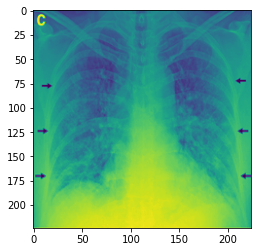

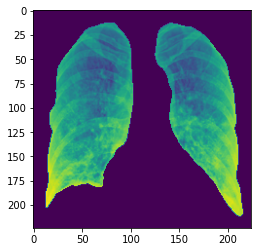

In [ ]:
j=np.random.randint(0,2000)
plt.imshow(X_train[j,:,:,0])
plt.show()
plt.imshow(train_Lungs_only[j,:,:,0])
plt.show()

In [13]:
train_Lungs_masks = None
valid_Lungs_masks  = None

del train_Lungs_masks
del valid_Lungs_masks

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
seed = 1
train_datagen.fit(train_Lungs_only)
train_datagen.fit(Y_train)

image_generator = train_datagen.flow(
    train_Lungs_only,
    batch_size=32,
    seed=seed)
mask_generator = train_datagen.flow(
    Y_train,
    batch_size=32,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [ ]:
seed = 1
test_datagen.fit(valid_Lungs_only)
test_datagen.fit(Y_valid)

image_generator = test_datagen.flow(
    valid_Lungs_only,
    batch_size=32,
    seed=seed)
mask_generator = test_datagen.flow(
    Y_valid,
    batch_size=32,
    seed=seed)
# combine generators into one which yields image and masks
validation_generator = zip(image_generator, mask_generator)

In [15]:
seed = 1
test_datagen.fit(test_Lungs_only)
test_datagen.fit(Y_test)

image_generator = test_datagen.flow(
    test_Lungs_only,
    batch_size=32,
    seed=seed)
mask_generator = test_datagen.flow(
    Y_test,
    batch_size=32,
    seed=seed)
# combine generators into one which yields image and masks
test_generator = zip(image_generator, mask_generator)

In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)
    densenet.trainable = True

    """ Encoder """
    s1 = densenet.get_layer(index=0).output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 224)
    d2 = decoder_block(d1, s3, 112)
    d3 = decoder_block(d2, s2, 56)
    d4 = decoder_block(d3, s1, 28)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

if __name__ == "__main__":
    input_shape = (224, 224, 3)
    model = build_densenet121_unet(input_shape)
    model.summary()


29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model_checkpoint_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5,verbose=1, mode='min', min_lr=1e-5)
callbacks_list = [checkpoint, reduceLROnPlat]

In [17]:
training_images_number = len(image_files_train)
validation_images_number = len(image_files_validation)
batchsize = 32
model.compile(optimizer=Adam(learning_rate=1e-4),loss=[dice_coef_loss],metrics = [dice_coef, 'binary_accuracy'])

In [ ]:
loss_history = model.fit(train_generator,
                         batch_size = 32,
                         steps_per_epoch=training_images_number//batchsize, 
                         epochs = 100,
                         validation_data =validation_generator ,
                         validation_steps=validation_images_number//batchsize,
                         callbacks=callbacks_list)

Epoch 1/100
62/62 [==============================] - 61s 701ms/step - loss: -0.4586 - dice_coef: 0.4586 - binary_accuracy: 0.8377 - val_loss: -0.2525 - val_dice_coef: 0.2525 - val_binary_accuracy: 0.8708

Epoch 00001: val_loss improved from inf to -0.25253, saving model to model_checkpoint_loss.h5
Epoch 2/100
62/62 [==============================] - 46s 667ms/step - loss: -0.5351 - dice_coef: 0.5350 - binary_accuracy: 0.8970 - val_loss: -0.2446 - val_dice_coef: 0.2446 - val_binary_accuracy: 0.8492

Epoch 00002: val_loss did not improve from -0.25253
Epoch 3/100
62/62 [==============================] - 41s 670ms/step - loss: -0.5587 - dice_coef: 0.5586 - binary_accuracy: 0.9078 - val_loss: -0.3365 - val_dice_coef: 0.3365 - val_binary_accuracy: 0.9061

Epoch 00003: val_loss improved from -0.25253 to -0.33654, saving model to model_checkpoint_loss.h5
Epoch 4/100
62/62 [==============================] - 41s 667ms/step - loss: -0.5813 - dice_coef: 0.5818 - binary_accuracy: 0.9172 - val_loss

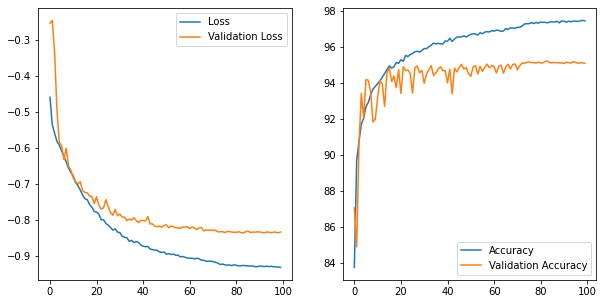

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [19]:
model.load_weights(filepath = 'model_checkpoint_loss.h5')
model.evaluate(test_generator,verbose=1,steps=validation_images_number//batchsize)

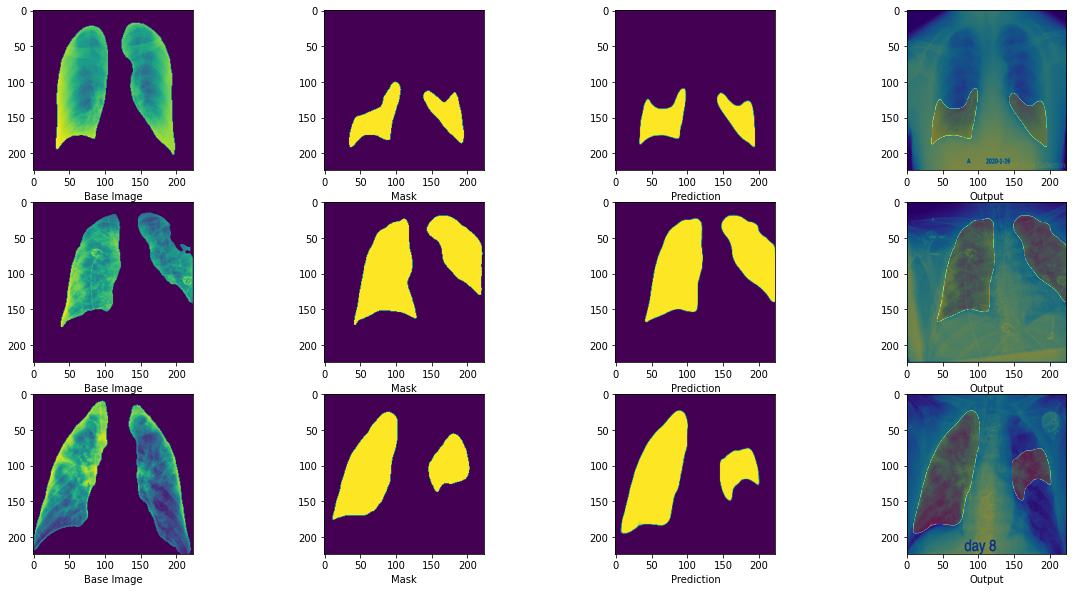

In [ ]:
j=np.random.randint(0,X_test.shape[0])
pred_candidates = np.random.randint(0,j,12)
preds = model.predict(np.expand_dims(test_Lungs_only[0]/255.0,axis=0))

plt.figure(figsize=(20,10))

for i in range(0,12,4):
    plt.subplot(3,4,i+1)
    
    plt.imshow(np.squeeze(test_Lungs_only[pred_candidates[i],:,:,0]/255.0))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,4,i+2)
    plt.imshow(np.squeeze(Y_test[pred_candidates[i],:,:,0]/255.0))
    plt.xlabel("Mask")
    
    plt.subplot(3,4,i+3)
    plt.imshow(np.squeeze(model.predict(np.expand_dims(test_Lungs_only[pred_candidates[i]]/255.0,axis=0))))
    plt.xlabel("Prediction")

    plt.subplot(3,4,i+4)
    plt.imshow(np.squeeze(X_test[pred_candidates[i],:,:,0]/255.0))
    plt.imshow(np.squeeze(model.predict(np.expand_dims(test_Lungs_only[pred_candidates[i]]/255.0,axis=0))),cmap='jet', alpha=0.4)
    plt.xlabel("Output")